In [1]:
from sklearn.neighbors import KernelDensity
from shapely.geometry import Point, Polygon
import geopandas
# from sklearn.cluster import DBSCAN
import pandas as pd
import torch
import numpy as np

In [4]:
from transformers import DistilBertTokenizerFast
# from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import RobertaForSequenceClassification , RobertaTokenizerFast, RobertaConfig

BASE_MODEL = 'models/2021-11-14_model-distilroberta-base_loss-huber_epoch-6/'

TOKEN_MODEL = 'distilroberta-base'
# tokenizer = DistilBertTokenizerFast.from_pretrained(TOKEN_MODEL)
# model = DistilBertForSequenceClassification.from_pretrained(BASE_MODEL)
tokenizer = RobertaTokenizerFast.from_pretrained(TOKEN_MODEL)
model = RobertaForSequenceClassification.from_pretrained(BASE_MODEL)

In [5]:
text = '''Since the beginning of November, there have been thousands of recorded border crossing attempts, according to Polish authorities.
A spokesperson for Poland's border guards told CNN on Monday that there had been "forced mass attempts to cross the border" in Kuznica area by a group of people over the weekend and that the situation was "very tense and very dangerous."
Last week, Polish border guard representatives told CNN that some of the migrants had been pushed toward the barriers by Belarusian services.
Speaking on Monday, Belarusian President Alexander Lukashenko said Belarus was doing everything to prevent people from accumulating at the border.
Polish authorities have detained small numbers of people, allowing only small numbers of people the option of applying for asylum in Poland. Others have been immediately sent back to Belarus.
Access to the border area is tightly restricted. Journalists and aid workers have been blocked from traveling to the area by an exclusion zone."'''

text = text.replace('\n', ' ').lower()
text_split = text.split()
n_steps = 20
step_size = int(len(text_split)/n_steps)
variations = [" ".join(text_split[:i]) + " " + " ".join(text_split[i+step_size:]) for i in range(n_steps)] 

In [6]:
tok = tokenizer(text, truncation=True, padding=True, return_tensors='pt')
out = model.forward(input_ids = tok['input_ids'], attention_mask=tok['attention_mask'], output_hidden_states=True)

In [7]:
last_hidden_state = out['hidden_states'][-1]

In [8]:
rand_locs = []
for i in range(500):
    ones = torch.ones_like(last_hidden_state)
    dim1 = ones.shape[1]
    dim2 = ones.shape[2]
    rand_dim1 = np.random.randint(0, dim1)
    rand_dim2 = np.random.randint(0, dim2)
    ones[0, :, rand_dim2] = 0
    masked = ones * last_hidden_state
    rand_loc = model.classifier(masked).cpu().detach().numpy().squeeze()
    rand_locs.append(rand_loc)

In [82]:
out_df = pd.DataFrame(rand_locs, columns=['lat', 'lon'])

In [148]:
kde = KernelDensity(kernel='gaussian', metric='haversine', bandwidth=0.05)

In [149]:
out_df *= np.pi / 180.0

In [150]:
kde.fit(out_df)

KernelDensity(bandwidth=0.05, metric='haversine')

In [151]:
conf_sample = kde.sample(100)
conf_probas = np.exp(kd.score_samples(conf_sample))
conf_probas /= conf_probas.sum()
conf_df = pd.Series(conf_probas, name='proba').to_frame()

In [152]:
# conf_df['point'] = geopandas.GeoSeries([Point(point[::-1]) for point in conf_sample])
conf_df.loc[:,['lat', 'lon']] = conf_sample

In [153]:
lat_mean = conf_df['lat'].mean()
lon_mean = conf_df['lon'].mean()

In [156]:
lat_space = np.linspace(-np.pi/2 , np.pi/2, 100) 
lon_space = np.linspace(-np.pi, np.pi, 100)
X, Y = np.meshgrid(lon_space,lon_space)
xy = np.vstack([Y.ravel(), X.ravel()]).T
Z = kde.score_samples(xy)
Z = Z.reshape(X.shape)

In [94]:
import matplotlib.pyplot as plt

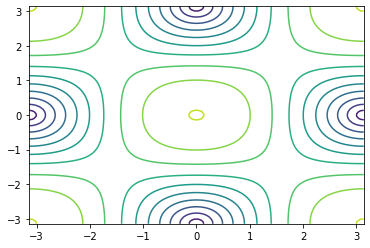

In [159]:
cont =plt.contour(X, Y, Z, 10)

In [27]:
conf_df['cdf'] = conf_df.sort_values('proba', ascending=False).proba.cumsum()

In [28]:
levels = 10

In [29]:
conf_df['conf_level'] = pd.qcut(conf_df.cdf, q=levels,labels=False)

In [30]:
# conf_layers = []
# dbscan = DBSCAN()
# for level in range(levels):
#     layer_points = conf_df[conf_df.conf_level >= level][['lat', 'lon']]
#     pred = dbscan.fit_predict(layer_points)
#     clusters = np.unique(pred)[1:]
#     layer_cluster_areas = []
#     for cluster in clusters:
#         layer_cluster_points = conf_df.loc[layer_points[pred == cluster].index]
#         conf_area_poly = Polygon(layer_cluster_points.point.values)
#         smoothed_area = conf_area_poly.convex_hull.buffer(.1,0,3,3, single_sided=True)
#         conf_layers.append(smoothed_area)

IllegalArgumentException: Shell is not a LinearRing


ValueError: Null geometry supports no operations

In [31]:

# conf_areas = []
# for level in range(levels):
#     conf_area_points = conf_df[conf_df.conf_level == level].point
#     conf_area_poly = Polygon(conf_area_points.values)
#     smoothed_area = conf_area_poly.convex_hull.buffer(.1,0,3,3, single_sided=True)
#     conf_areas.append(smoothed_area)

In [ ]:
conf_area_series = geopandas.GeoSeries(conf_layers)

In [ ]:
conf_area_series

In [ ]:
import folium
from folium.plugins import HeatMap

In [ ]:
maploc = folium.Map(
#     location=[conf_df.lon.mean(), conf_df.lat.mean()],
    zoom_start=11,
    tiles="Stamen Toner", 
    min_lat=conf_df['point'].map(lambda x: x.x).min(), 
    max_lat=conf_df['point'].map(lambda x: x.x).max(),
    min_lon=conf_df['point'].map(lambda x: x.y).min(),
    max_lon=conf_df['point'].map(lambda x: x.y).max())
maploc.add_child(folium.GeoJson(
    data=conf_area_series.to_json(), 
    style_function=lambda x: {'fillColor': 'blue', 'stroke': False, 'fillOpacity': 0.1}))
maploc.add_child(HeatMap(conf_sample))
maploc

In [34]:
out_df.to_xml('test.xml')

In [33]:
pd.__version__

'1.3.4'

In [1476]:
!pip install -U pandas

In [162]:
path = geopandas.datasets.get_path('naturalearth_lowres')
df = geopandas.read_file(path)

IllegalArgumentException: Shell is not a LinearRing
IllegalArgumentException: Shell is not a LinearRing
IllegalArgumentException: Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

IllegalArgumentException: Shell is not a LinearRing
IllegalArgumentException: Shell is not a LinearRing
IllegalArgumentException: Shell is not a LinearRing
IllegalArgumentException: Shell is not a LinearRing
IllegalArgumentException: Shell is not a LinearRing
IllegalArgumentException: Shell is not a LinearRing
IllegalArgumentException: Shell is not a LinearRing
IllegalArgumentException: Shell is not a LinearRing
IllegalArgumentException: Shell is not a LinearRing
IllegalArgumentException: Shell is not a LinearRing
IllegalArgumentException: Shell is not a LinearRing
IllegalArgumentException: Shell is not a LinearRing
IllegalArgumentException: Shell is not a LinearRing
IllegalArgumentException: Shell is not a LinearRing
IllegalArgumentException: Shell is not a Linear

In [163]:
df.plot()

/Users/hhoferic/anaconda3/lib/python3.8/site-packages/geopandas/array.py:918: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 0]),  # minx
/Users/hhoferic/anaconda3/lib/python3.8/site-packages/geopandas/array.py:919: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 1]),  # miny
/Users/hhoferic/anaconda3/lib/python3.8/site-packages/geopandas/array.py:920: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 2]),  # maxx
/Users/hhoferic/anaconda3/lib/python3.8/site-packages/geopandas/array.py:921: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 3]),  # maxy
/Users/hhoferic/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:410: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  warnings.warn(


<AxesSubplot:>

ValueError: cannot convert float NaN to integer

<Figure size 432x288 with 1 Axes>